In [5]:
from riskeye.cogmodels.fit_model import build_model, get_data
import arviz as az
from riskeye.cogmodels.utils import plot_ppc
from bauer.utils.math import softplus_np

In [3]:
df = get_data('/data/ds-riskeye', '1')
model = build_model('1', df)

In [4]:
idata = az.from_netcdf("/data/ds-riskeye/derivatives/cogmodels/model-1_trace.netcdf")

In [6]:
import pandas as pd

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_9224/3129292819.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(traces['n1_evidence_sd'].xs('exptype[T.symbolic]', 0, -1))


<Axes: ylabel='Density'>

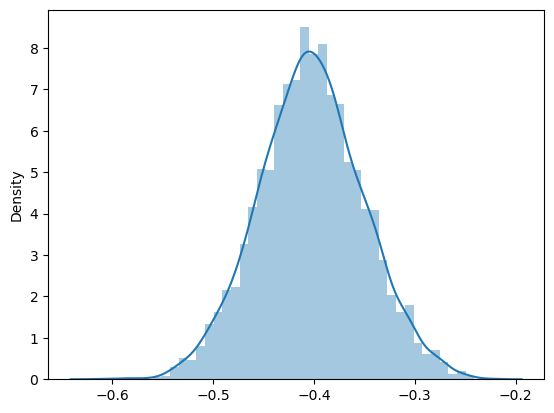

In [18]:
sns.distplot(traces['n1_evidence_sd'].xs('exptype[T.symbolic]', 0, -1))

In [19]:
traces = {}

pars_ns = []
pars_s = []

keys = ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_mu', 'risky_prior_std', 'safe_prior_mu', 'safe_prior_std']

for key in keys:
    traces[key] = idata.posterior[f'{key}_mu'].to_dataframe()

    non_symbolic_values = traces[key].xs('Intercept', 0, f'{key}_regressors')
    symbolic_values = non_symbolic_values + traces[key].xs('exptype[T.symbolic]', 0, f'{key}_regressors')

    if key in ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_std', 'safe_prior_std']:
        non_symbolic_values = softplus_np(non_symbolic_values)
        symbolic_values = softplus_np(symbolic_values)

    pars_ns.append(non_symbolic_values)
    pars_s.append(symbolic_values)


pars_ns = pd.concat(pars_ns, axis=1)
pars_s = pd.concat(pars_s, axis=1)

pars = pd.concat((pars_ns, pars_s), keys=['non-symbolic', 'symbolic'], names=['exptype'])
pars.columns.name = 'parameter'
pars = pars.stack().to_frame('value')

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


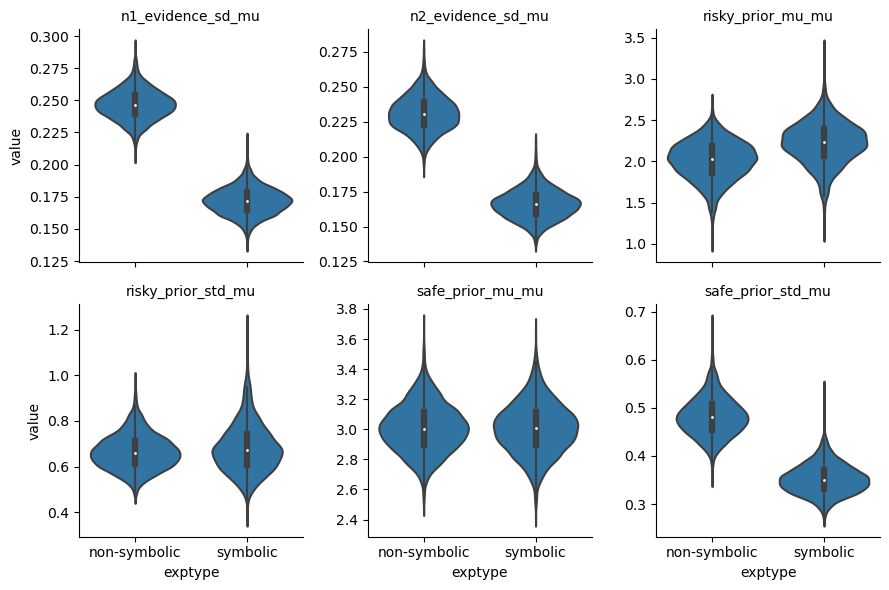

In [20]:
import seaborn as sns

g = sns.FacetGrid(pars.reset_index(), col='parameter', sharey=False, col_wrap=3)

g.map(sns.violinplot, 'exptype', 'value', fill=True, col_wrap=3)
g.set_titles('{col_name}')

In [22]:
model.build_estimation_model()
ppc = model.ppc(df, idata)

In [27]:
ppc.loc[ppc.index.get_level_values('risky_first')] = 1 - ppc.loc[ppc.index.get_level_values('risky_first')]

In [28]:
from riskeye.cogmodels.utils import plot_ppc

/Users/gdehol/git/riskeye/riskeye/cogmodels/utils.py:79: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,


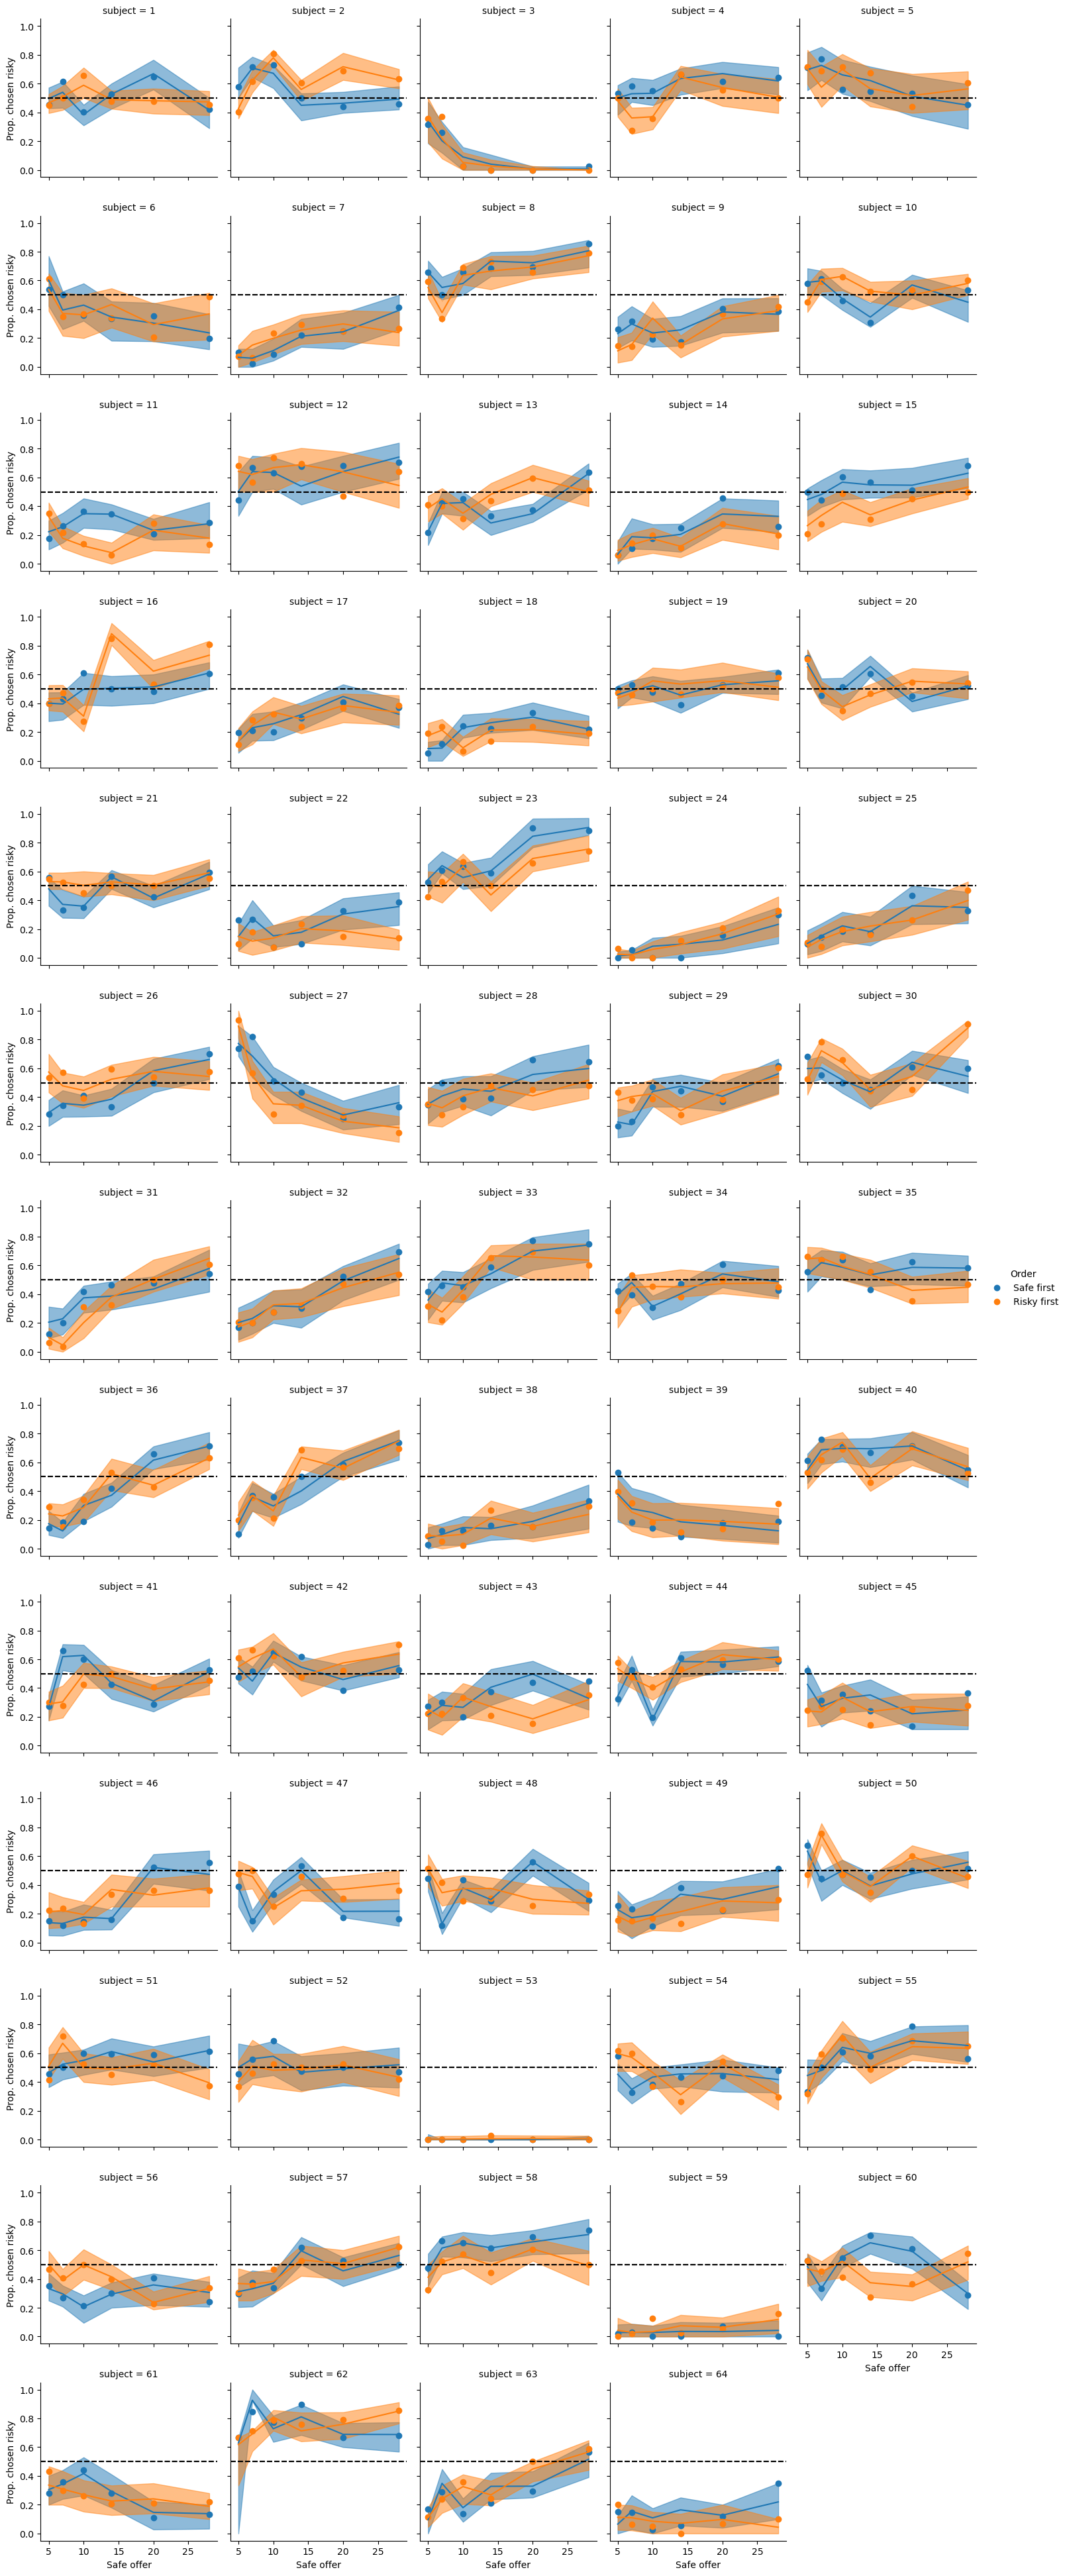

In [30]:
plot_ppc(df, ppc, level='subject', plot_type=2)

In [41]:
pars

value
exptype      chain draw parameter                   
non-symbolic 0     0    n1_evidence_sd_mu   0.256495
                        n2_evidence_sd_mu   0.246224
                        risky_prior_mu_mu   1.876632
                        risky_prior_std_mu  0.615836
                        safe_prior_mu_mu    2.925322
...                                              ...
symbolic     3     999  n2_evidence_sd_mu   0.153417
                        risky_prior_mu_mu   1.853754
                        risky_prior_std_mu  0.783162
                        safe_prior_mu_mu    2.683730
                        safe_prior_std_mu   0.330905

[48000 rows x 1 columns]

In [42]:
traces = {}

pars_ns = []
pars_s = []

keys = ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_mu', 'risky_prior_std', 'safe_prior_mu', 'safe_prior_std']

for key in keys:
    traces[key] = idata.posterior[f'{key}'].to_dataframe()

    non_symbolic_values = traces[key].xs('Intercept', 0, f'{key}_regressors')
    symbolic_values = non_symbolic_values + traces[key].xs('exptype[T.symbolic]', 0, f'{key}_regressors')

    if key in ['n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_std', 'safe_prior_std']:
        non_symbolic_values = softplus_np(non_symbolic_values)
        symbolic_values = softplus_np(symbolic_values)

    pars_ns.append(non_symbolic_values)
    pars_s.append(symbolic_values)


pars_ns = pd.concat(pars_ns, axis=1)
pars_s = pd.concat(pars_s, axis=1)

pars = pd.concat((pars_ns, pars_s), keys=['non-symbolic', 'symbolic'], names=['exptype'])
pars.columns.name = 'parameter'
pars = pars.stack().to_frame('value')

value
exptype      chain draw subject parameter               
non-symbolic 0     0    1       n1_evidence_sd  0.146155
                                n2_evidence_sd  0.219970
                        2       n1_evidence_sd  0.098466
                                n2_evidence_sd  0.206029
                        3       n1_evidence_sd  0.260977
...                                                  ...
symbolic     3     999  62      n2_evidence_sd  0.152306
                        63      n1_evidence_sd  0.113430
                                n2_evidence_sd  0.179713
                        64      n1_evidence_sd  0.249336
                                n2_evidence_sd  0.206044

[1024000 rows x 1 columns]

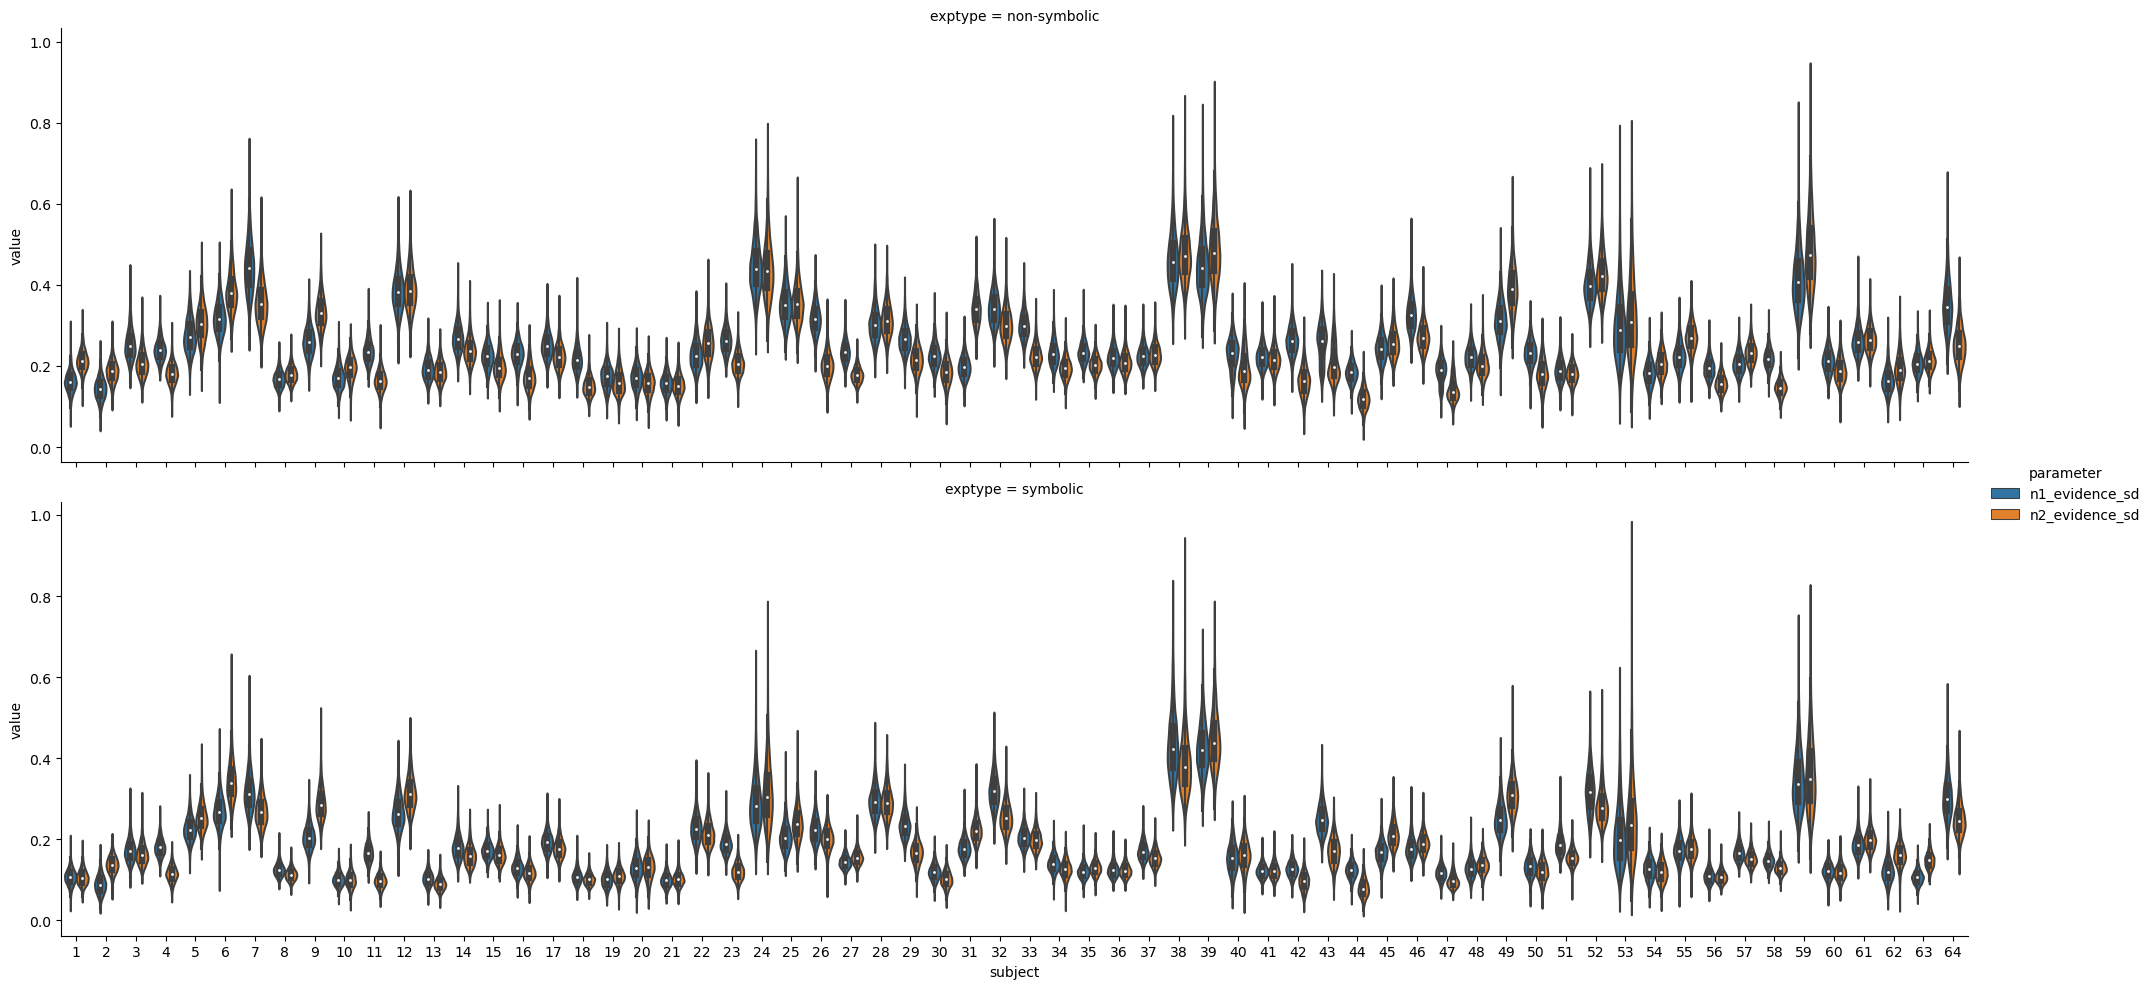

In [47]:
tmp = pd.concat((pars.xs('n1_evidence_sd', 0, -1, drop_level=False), pars.xs('n2_evidence_sd', 0, -1, drop_level=False))).sort_index()

sns.catplot(x='subject', y='value', row='exptype', hue='parameter', data=tmp.reset_index(), kind='violin', aspect=4)
tmp

value
exptype      chain draw subject parameter               
non-symbolic 0     0    1       risky_prior_mu  1.023177
                                safe_prior_mu   2.385451
                        2       risky_prior_mu  3.248190
                                safe_prior_mu   2.272103
                        3       risky_prior_mu  2.409331
...                                                  ...
symbolic     3     999  62      safe_prior_mu   2.659942
                        63      risky_prior_mu  2.553595
                                safe_prior_mu   3.616024
                        64      risky_prior_mu  1.527964
                                safe_prior_mu   2.337327

[1024000 rows x 1 columns]

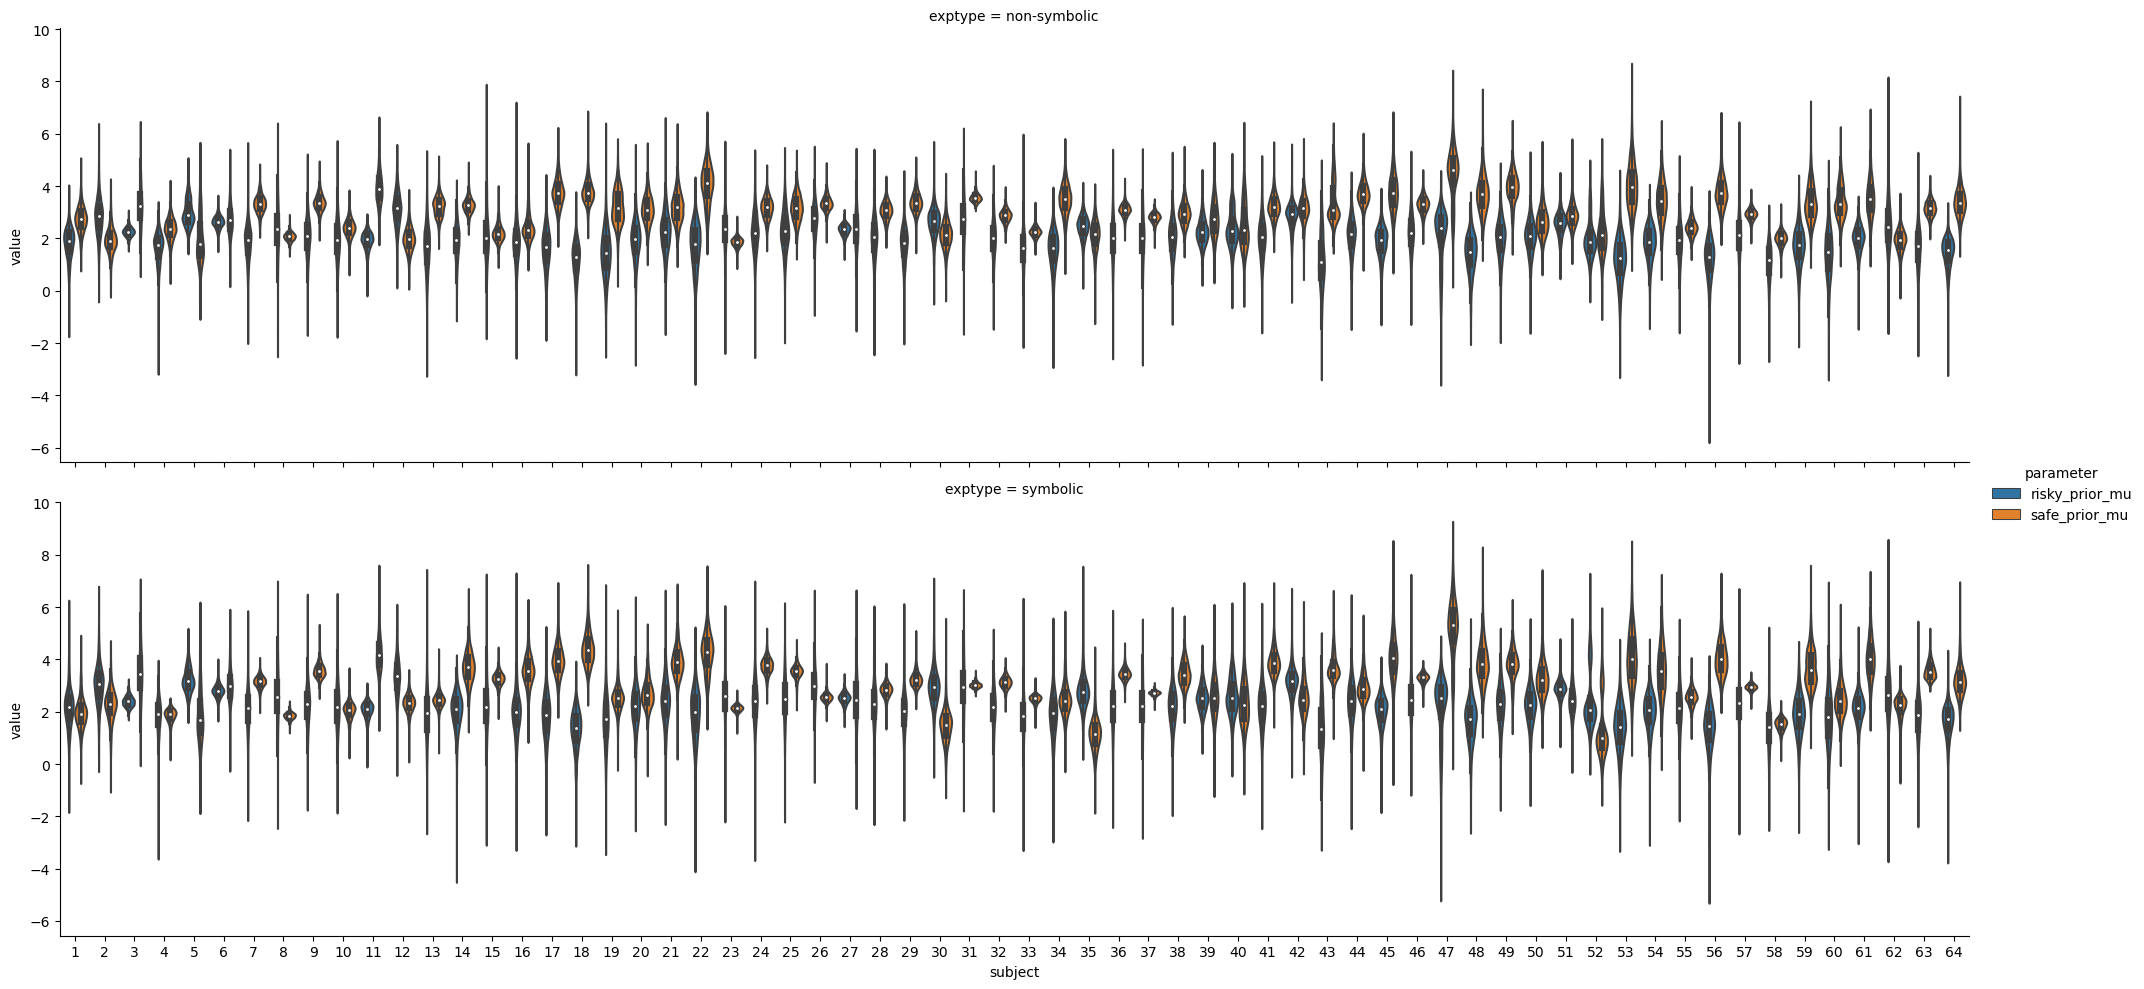

In [48]:
tmp = pd.concat((pars.xs('risky_prior_mu', 0, -1, drop_level=False), pars.xs('safe_prior_mu', 0, -1, drop_level=False))).sort_index()

sns.catplot(x='subject', y='value', row='exptype', hue='parameter', data=tmp.reset_index(), kind='violin', aspect=4)
tmp